In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
# from sklearn import datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
from sam.sam import SAM

from mega_sam_feri import MegaSAM
from NN_utils import train_multi_model
from data.mnist import mnist_data_gen
import pickle
import blosc


In [13]:
with open("compressed_training", "rb") as f:
    compressed_pickle = f.read()

depressed_pickle = blosc.decompress(compressed_pickle)
training_set = pickle.loads(depressed_pickle)  # turn bytes object back into data

with open("compressed_test", "rb") as f:
    compressed_pickle = f.read()

depressed_pickle = blosc.decompress(compressed_pickle)
test_set = pickle.loads(depressed_pickle)

# with open ('compressed_training', 'rb') as fp:
#     training_set = pickle.load(fp)
# with open ('compressed_test', 'rb') as fp:
#     test_set = pickle.load(fp)

In [14]:
# We can compress data like this
# import blosc
# pickled_data = pickle.dumps(test_set)  # returns data as a bytes object
# compressed_pickle = blosc.compress(pickled_data)

# with open("compressed_test", "wb") as f:
#     f.write(compressed_pickle)

In [15]:
output1 = 32
output2 = 32

MLP = nn.Sequential(
    nn.Linear(28 * 28, output1),
    nn.ReLU(),
    nn.Linear(output1, output2),
    nn.ReLU(),
    nn.Linear(output2, 10))

In [16]:
model, training_losses, training_accuracies, validation_accuracies, optimizer = train_multi_model(train_data=training_set, test_data=test_set, model=MLP,
                        optim="MegaSAM", batch_size=128, epochs=5, tracking=True, alpha=.2, lr_M=10, lr=.2)
                        

In [17]:
print(optimizer.M_param_groups[0]['params'][0])

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], requires_grad=True)


In [18]:
print(list(model[0].parameters()))

[Parameter containing:
tensor([[-0.0146,  0.0220,  0.0067,  ...,  0.0196,  0.0203,  0.0347],
        [-0.0201,  0.0097,  0.0200,  ...,  0.0019,  0.0160,  0.0002],
        [ 0.0017,  0.0081, -0.0111,  ...,  0.0064,  0.0325, -0.0331],
        ...,
        [ 0.0059,  0.0145, -0.0039,  ...,  0.0277, -0.0061, -0.0216],
        [-0.0185,  0.0319,  0.0087,  ..., -0.0109,  0.0314, -0.0155],
        [-0.0102,  0.0069, -0.0207,  ...,  0.0142, -0.0102, -0.0339]],
       requires_grad=True), Parameter containing:
tensor([-0.0471,  0.1136,  0.0833,  0.5108, -0.0176,  0.2771,  0.1230, -0.1573,
         0.1569, -0.0154,  0.0959,  0.1819, -0.1388, -0.0134,  0.0625,  0.0080,
         0.1717, -0.0270, -0.0455,  0.0212,  0.2522,  0.0606, -0.0045,  0.0291,
         0.3789,  0.1190, -0.0973,  0.0946,  0.0397,  0.0204, -0.0775, -0.0219],
       requires_grad=True)]


In [19]:
print(f"MegaSAM training accuracies: {training_accuracies}")
print(f"MegaSAM validation accuracies: {validation_accuracies}")

MegaSAM training accuracies: [0.8165666460990906, 0.934583306312561, 0.9509333372116089, 0.9598833322525024, 0.9651166796684265]
MegaSAM validation accuracies: [0.9223999977111816, 0.9466000199317932, 0.9556999802589417, 0.9580000042915344, 0.9645000100135803]


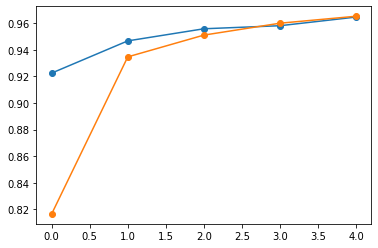

In [20]:
plt.plot(validation_accuracies, 'o-')
plt.plot(training_accuracies, 'o-')

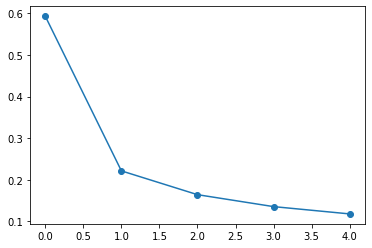

In [21]:
plt.plot(training_losses, 'o-')